In [1]:
%matplotlib inline
import numpy as np
import math
import scipy as sc
import time, datetime
import pandas as pd
import random
import matplotlib.pyplot as plt
from numpy import *
from sklearn import metrics
import seaborn as sns
from collections import Counter
from scipy import stats, integrate
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn import cross_validation

/Users/MoniaBayakissa/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
orders = '../Weather_Impact/example_orders.csv'
weather = '../Weather_Impact/example_weather.csv'

In [3]:
orders_df = pd.read_csv(orders, sep=',',header=0, encoding='latin-1', error_bad_lines=False,index_col = 0)
weather_df = pd.read_csv(weather, sep=',',header=0, encoding='latin-1', date_parser=lambda t: datetime.date.strptime(t, '%Y-%m-%d').date(), error_bad_lines=False)

In [4]:
orders_df, weather_df

(        cancelled_reason  user_id         day
 0                      0     5115  2013-01-01
 1                      0    15932  2013-01-01
 2                      0    20331  2013-01-01
 3                      0    20339  2013-01-01
 4                      0    19304  2013-01-01
 5                      0     7224  2013-01-01
 6                      0    19803  2013-01-01
 7                      0     9813  2013-01-01
 8                      0    17975  2013-01-01
 9                      0    12325  2013-01-01
 10                     0     1451  2013-01-01
 11                     0     7695  2013-01-01
 12                     0    15706  2013-01-01
 13                     0     4014  2013-01-01
 14                     0    17924  2013-01-01
 15                     0     1592  2013-01-01
 16                     0    11143  2013-01-01
 17                     0     1457  2013-01-01
 18                     0    17146  2013-01-01
 19                     0    20691  2013-01-01
 20          

In [5]:
# Converting dates to the same format

weather_df['Time'] = pd.to_datetime(weather_df['Time'])
weather_df['Time'] = weather_df['Time'].apply(lambda x:x.date().strftime('%d/%m/%Y'))

orders_df['day'] = pd.to_datetime(orders_df['day'])
orders_df['day'] = orders_df['day'].apply(lambda x:x.date().strftime('%d/%m/%Y'))

In [6]:
# Rearranging dataset and summing precipitation per day

weather_df = weather_df.drop(['Unnamed: 2', 'Unnamed: 3'], 1)
weather_df = weather_df[weather_df['Precipitation'] != 'n/a']
weather_df['Precipitation'] = [ float(_) for _ in weather_df['Precipitation']]
weather_df = weather_df.groupby(by=['Time'], as_index=False)['Precipitation'].sum()

In [7]:
orders_df

,cancelled_reason,user_id,day
0,0,5115,01/01/2013
1,0,15932,01/01/2013
2,0,20331,01/01/2013
3,0,20339,01/01/2013
4,0,19304,01/01/2013
5,0,7224,01/01/2013
6,0,19803,01/01/2013
7,0,9813,01/01/2013
8,0,17975,01/01/2013
9,0,12325,01/01/2013


/Users/MoniaBayakissa/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


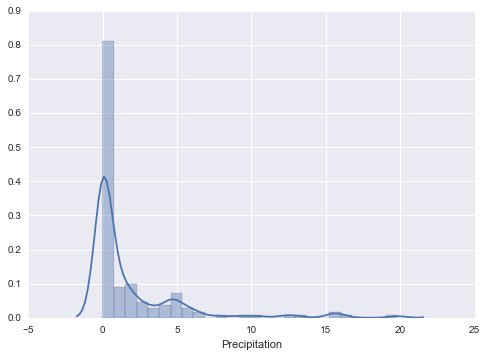

In [8]:
sns.distplot(weather_df.Precipitation)

In [9]:
# Joining both datasets by date

order_weather = orders_df.merge(weather_df, left_on=['day'], right_on=['Time'], how='inner')
order_weather = order_weather.drop('Time', 1)

In [10]:
order_weather

,cancelled_reason,user_id,day,Precipitation
0,0,16496,13/12/2013,0.2
1,0,1014,13/12/2013,0.2
2,0,16522,13/12/2013,0.2
3,0,26328,13/12/2013,0.2
4,0,7138,13/12/2013,0.2
5,0,16311,13/12/2013,0.2
6,0,34553,13/12/2013,0.2
7,0,28287,13/12/2013,0.2
8,0,6829,13/12/2013,0.2
9,0,39337,13/12/2013,0.2


In [12]:
threshold = weather_df.Precipitation.mean()
threshold

1.870833333333334

Considering Jinn is a 24h service platform AND we only have here the date of order not the time, we will consider the sum of precipitation for the whole day to categorize it as a 'rainy day' or not.

Researches have provided the information that a rainy day (London) is a day where 1mm of rain or more falls (Met Office Climate).
The mean of precipitation in our dataset is about 1.8 mm, so this is the threshold we are going to use to define a rainy day here.

We can then divide the data between days with < 1.8 mm of rain and days with >= 1.8 mm of rain.

In [23]:
categorize = order_weather.groupby('user_id').size()
categorize

user_id
0         4
1        13
2        16
3        49
4        61
5        28
6         2
7        11
8         1
9         2
10       16
11        1
12        1
13        2
15        2
16        1
17        1
18        9
19       12
20        3
21       48
23       10
24        5
25       11
27        1
28        6
29        4
30       40
31       12
32       34
         ..
53625     2
53652     1
53668     1
53678     1
53682     1
54057     1
54402     1
54687     1
54851     1
54891     1
54930     1
55159     1
55239     1
55260     1
55515     1
55668     1
55769     1
55918     1
55923     1
55924     1
55926     1
55927     1
55931     1
55932     1
55933     1
55935     1
55936     1
55939     1
55941     1
55942     1
dtype: int64

Just from these results, we could answer (considering the present dataset) that people order more when it's _not_ rainy.


But now as a classification model, we can also use this threshold to automatically classify them.

In [14]:
order_weather['Rainy_Day'] = pd.Series(np.random.randn(len(order_weather)), index=order_weather.index)

order_weather.Rainy_Day = [1 if _ >= threshold else 0 for _ in order_weather.Precipitation]

In [27]:
order_weather = order_weather.drop(['day'], 1)

In [20]:
order_weather[order_weather.user_id == 3]

,cancelled_reason,user_id,day,Precipitation,Rainy_Day
11269,0,3,03/01/2014,0.0,0
12861,0,3,05/01/2014,0.2,0
13657,0,3,13/01/2014,0.0,0
14430,0,3,14/01/2014,0.0,0
15146,0,3,15/01/2014,0.0,0
15738,0,3,16/01/2014,0.2,0
15755,0,3,16/01/2014,0.2,0
16567,0,3,17/01/2014,0.4,0
20070,0,3,21/01/2014,0.2,0
20071,0,3,21/01/2014,0.2,0


In [36]:
Counter(order_weather.user_id)[1]

13

In [37]:
order_weather[order_weather.user_id == 1]

,cancelled_reason,user_id,day,Precipitation,Rainy_Day
770,0,1,14/12/2013,4.2,1
1901,0,1,17/12/2013,0.6,0
6194,0,1,25/12/2013,1.2,0
28615,0,1,01/02/2014,0.0,0
28658,0,1,01/02/2014,0.0,0
41825,0,1,22/02/2014,0.0,0
51352,0,1,04/03/2014,0.0,0
57585,0,1,19/03/2014,0.8,0
57857,0,1,19/03/2014,0.8,0
66416,0,1,30/03/2014,0.0,0


In [59]:
order_weather.user_id.unique()[2]

16522

In [60]:
order_weather[order_weather.user_id == 16522]

,cancelled_reason,user_id,day,Precipitation,Rainy_Day
2,0,16522,13/12/2013,0.2,0
3643,0,16522,21/12/2013,6.6,1
16737,0,16522,17/01/2014,0.4,0
21692,0,16522,23/01/2014,0.0,0


In [61]:
cat = order_weather.groupby(by=['user_id'], as_index=False)['Rainy_Day'].sum()
cat

,user_id,Rainy_Day
0,0,3
1,1,2
2,2,7
3,3,9
4,4,16
5,5,7
6,6,2
7,7,4
8,8,1
9,9,1


In [31]:
rain = order_weather.groupby(by=['user_id'], as_index=False)['Rainy_Day'].sum()
rain.Rainy_Day

0         3
1         2
2         7
3         9
4        16
5         7
6         2
7         4
8         1
9         1
10        6
11        1
12        1
13        2
14        2
15        1
16        1
17        4
18        5
19        1
20       14
21        8
22        5
23        4
24        1
25        5
26        2
27       12
28        5
29       10
         ..
21428     2
21429     1
21430     0
21431     1
21432     1
21433     1
21434     1
21435     1
21436     1
21437     1
21438     0
21439     1
21440     1
21441     0
21442     1
21443     1
21444     1
21445     1
21446     1
21447     1
21448     1
21449     1
21450     1
21451     1
21452     1
21453     1
21454     1
21455     1
21456     1
21457     1
Name: Rainy_Day, dtype: int64

In [65]:
grp = order_weather.groupby('user_id')
grp[['Rainy_Day']].transform(sum).sort('Rainy_Day')

/Users/MoniaBayakissa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Rainy_Day
100194,0
86576,0
13214,0
13213,0
100069,0
13211,0
100071,0
100068,0
13208,0
100073,0


In [43]:
Counter(order_weather.user_id)[Counter(order_weather.user_id) != 1]


13

In [40]:
Counter(order_weather.user_id)

Counter({0: 4,
         1: 13,
         2: 16,
         3: 49,
         4: 61,
         5: 28,
         6: 2,
         7: 11,
         8: 1,
         9: 2,
         10: 16,
         11: 1,
         12: 1,
         13: 2,
         15: 2,
         16: 1,
         17: 1,
         18: 9,
         19: 12,
         20: 3,
         21: 48,
         23: 10,
         24: 5,
         25: 11,
         27: 1,
         28: 6,
         29: 4,
         30: 40,
         31: 12,
         32: 34,
         33: 9,
         34: 11,
         35: 25,
         36: 8,
         38: 5,
         39: 7,
         40: 1,
         41: 30,
         42: 1,
         44: 3,
         46: 1,
         47: 1,
         49: 2,
         50: 12,
         52: 7,
         54: 8,
         55: 3,
         56: 3,
         57: 2,
         58: 1,
         59: 1,
         60: 1,
         61: 1,
         62: 12,
         63: 15,
         64: 1,
         65: 4,
         66: 2,
         67: 17,
         68: 3,
         69: 1,
         70: 

In [46]:
categorize = pd.DataFrame({'User_Id': [], 'Count_Order': [], 'Mean_Rain': []})

for i in range(len(order_weather.user_id.unique())):
    if Counter(order_weather.user_id)[i] != 1:
        tmp = pd.DataFrame({'User_Id': [cat.user_id[i]], 'Count_Order': [Counter(order_weather.user_id)[i]], 'Mean_Rain': [rain.Rainy_Day[i] / Counter(order_weather.user_id)[i]]})
        categorize = categorize.append(tmp)


In [47]:
categorize

,Count_Order,Mean_Rain,User_Id
0,4.0,0.750000,0.0
0,13.0,0.153846,1.0
0,16.0,0.437500,2.0
0,49.0,0.183673,3.0
0,61.0,0.262295,4.0
0,28.0,0.250000,5.0
0,2.0,1.000000,6.0
0,11.0,0.363636,7.0
0,2.0,0.500000,9.0
0,16.0,0.375000,10.0


In [49]:
len(categorize[categorize.Mean_Rain >= 0.5]), len(categorize[categorize.Mean_Rain < 0.5])

(7448, 6664)

Based on this results, we could conclude people seem to be more likely to order on "rainy days".